<a href="https://colab.research.google.com/github/StevenMena/05MIAR---Aprendizaje_Supervisado/blob/main/Actividad_C1_P1_MenaChavez_StevenAlberto_histo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

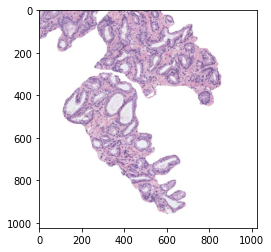

In [43]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = io.imread('histo_2.jpg')

rgb = img.copy()
rgb_p = rgb.astype('uint8')/255

plt.imshow(rgb_p,cmap='gray')




#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

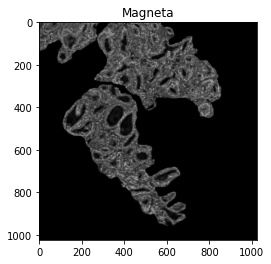

In [45]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta


with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(rgb_p, axis=2)
    C = (1-rgb_p[:,:,0] - K)/(1-K)
    M = (1-rgb_p[:,:,1] - K)/(1-K)
    Y = (1-rgb_p[:,:,2] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype(np.uint8)
C,M,Y,K = cv2.split(CMYK)

magneta=M.astype('uint8')

plt.title('Magneta')
plt.imshow(magneta,cmap='gray')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

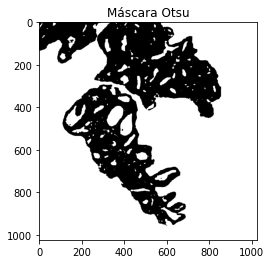

In [46]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

#Filtro gaussiano de 5x5
imagen_gauss = cv2.GaussianBlur(magneta,(5,5),0)

t, otsu_mask = cv2.threshold(imagen_gauss,0,1,cv2.THRESH_OTSU)

otsu_mask = (1-otsu_mask).astype('uint8')
#print(np.unique(otsu_mask))
plt.title('Máscara Otsu')
plt.imshow(otsu_mask,cmap='gray')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

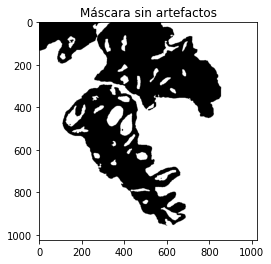

In [47]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
from skimage import morphology

arr = otsu_mask > 0
mask_2=morphology.remove_small_objects(arr,min_size=300)

plt.title('Máscara sin artefactos')
plt.imshow(mask_2,cmap='gray')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

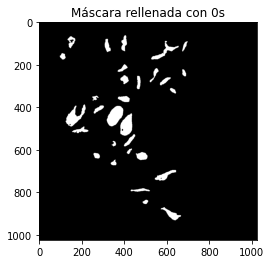

In [50]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 
mask_3 = mask_2.copy()
mask_3 = mask_3.astype('uint8')
h, w = mask_3.shape
ref = np.zeros((h+2, w+2), np.uint8)

#Semillas
#Solo ocupar esta semilla para la imagen histo_1.png
cv2.floodFill(mask_3, ref, (0,0), 0) # Como nos interesa rellenar de negro, utilizamos el par 0,0 ya que nos hemos percato que es un punto donde se puede iniciar a rellenar con 0
# La segunda se pone el par 1000,1000, ya que la imagen se parte en 2, y la semilla no puede seguir buscando más regiones con 1
cv2.floodFill(mask_3, ref, (1000,1000), 0) 

plt.title('Máscara rellenada con 0s')
plt.imshow(mask_3,cmap='gray')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

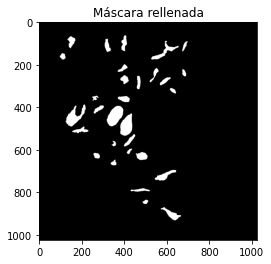

In [51]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy import  ndimage

mask_4=ndimage.morphology.binary_fill_holes(mask_3)
plt.title('Máscara rellenada')
plt.imshow(mask_4,cmap='gray')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

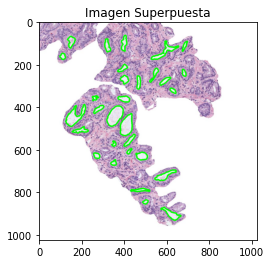

In [52]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

img_superpuesta = img.copy()

contours,_ = cv2.findContours(mask_4.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#Dibujar contornos
cv2.drawContours(img_superpuesta,contours,-1,(0,255,0),6)

plt.title('Imagen Superpuesta')
plt.imshow(img_superpuesta,cmap='gray')
plt.show()


#### 7) Identificar y cropear el lumen más grande

(394, 318, 490, 396)


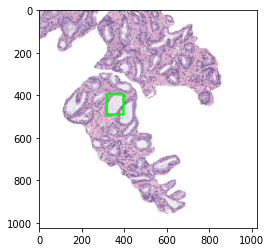

318


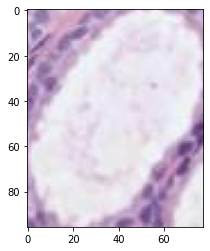

In [53]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

from skimage.measure import label
from skimage.measure import regionprops

#cada num tiene un grado de intensidad para cada imagen 
lab, num = label(mask_4, return_num=True)

img_copy =img.copy()
#Objeto donde se guardara el objeto de mayor área
obj_mayor_area = {}
area = 0 

for i in range(1,num+1):
    objeto = lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    if(area<np.round(prop[0].area, 4)):
      area = np.round(prop[0].area, 4)
      obj_mayor_area = objeto
    

obj_mayor_area = obj_mayor_area.astype('uint8')
bbox = regionprops(obj_mayor_area)[0].bbox
print(bbox)
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 10)
                     
plt.imshow(window, cmap='gray')
plt.show()

##Crop image
x,y,w,h = bbox
print(y)
img_crop=img[x:w, y:h]
plt.imshow(img_crop, cmap='gray')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [54]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
from tabulate import tabulate
import math



# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

headers = ['','Lumen mayor área']
A,BB,CA,E,ED,EX,DF,MA,MiA,OR,P,S,CO = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
['Extensión'], ['Diámetro Feret'],['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad']

prop = regionprops(obj_mayor_area)
    
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
DF.append(np.round(prop[0].feret_diameter_max, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))



my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), tuple(DF), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print(tabulate(my_data, headers=headers))


                           Lumen mayor área
-----------------------  ------------------
Área                              4881
Área de la bounding box           7488
Área convexa                      5013
Exentricidad                         0.835
Diámetro equivalente                78.8333
Extensión                            0.6518
Diámetro Feret                     105.679
Longitud del eje mayor             106.505
Longitud del eje menor              58.5976
Orientación                         -0.5613
Perímetro                          280.978
Solidez                              0.9737
Compacidad                           0.7769
